# Using transfer learning from VGG16 to do 10 class classification of the STL10 dataset
Using the subroutine stl10_input by Martin Tutek in link https://cs.stanford.edu/~acoates/stl10/

In [1]:
from stl10_input import *
import pandas as pd
import os
%matplotlib inline

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)


In [2]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [4]:
path_to_data='./data/stl10_binary/train_X.bin'
path_to_labels='./data/stl10_binary/train_y.bin'
images=read_all_images(path_to_data)
labels=read_labels(path_to_labels)
N=images.shape[0]
print(images.shape, labels.shape)

(5000, 96, 96, 3) (5000,)


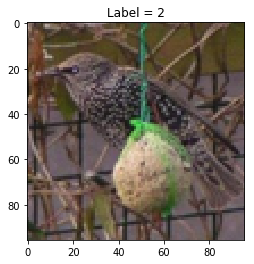

In [5]:
ii=20
plot_image(images[ii,:],labels[ii])

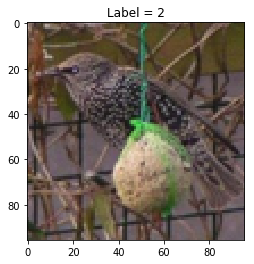

In [6]:
# normalize inputs from 0-255 to 0.0-1.0
images = (images.astype('float32')) / 255.0
ii=20
plot_image(images[ii,:],labels[ii])


In [7]:
file_indices='./data/stl10_binary/fold_indices.txt'
idxtrain=pd.read_table(file_indices, header=None, sep=" ")
idxtrain.dropna(axis=1, inplace=True)
idxtrain.apply(pd.to_numeric)
print(idxtrain.shape, np.max(np.max(idxtrain)), np.min(np.min(idxtrain)))
idxtrain

(10, 1000) 4999 0


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,39,4948,2964,2855,1866,1306,2954,1040,2450,1829,...,3286,3239,2561,3463,735,4171,4532,1405,2918,4930
1,2568,1657,2871,579,3380,1484,4372,2989,2126,2947,...,3745,1319,19,163,2829,4091,1489,2555,3176,2634
2,1355,3916,3348,3417,2726,3245,41,3239,313,1053,...,1136,89,2167,3354,846,849,2823,4914,2491,426
3,2373,2831,950,4558,832,142,3940,2563,656,937,...,14,3333,1601,1962,477,3912,2363,68,815,1226
4,1632,1914,1739,4639,1009,4160,4035,2197,2513,4705,...,3497,3540,1654,2899,2508,3850,1121,3042,4757,3733
5,3771,4715,3997,3070,1761,1449,1072,2169,4034,340,...,920,2973,2753,3010,1307,1459,2388,1126,4618,1273
6,4238,4712,2526,3864,2139,4050,3996,2428,1806,3351,...,1220,4267,1966,316,3574,4079,478,32,2383,2943
7,1256,2554,292,2766,4474,2923,4631,2857,1641,1745,...,3564,967,1184,4168,857,339,2410,185,3543,696
8,987,190,3556,4805,4643,698,3003,3977,2969,2259,...,1234,968,4179,2089,505,4903,4935,1132,907,3411
9,2570,1868,4671,631,3831,488,4305,2339,3324,3155,...,2902,1516,1273,3477,3392,2118,4311,2654,1544,261


In [8]:
#create train/test datasets from indices
def create_train_val(images, labels, index_train):
    N,L,L,d=images.shape
    flat1=images.reshape(N,L*L*d)
    index_train=np.array(index_train)
    idt=np.array([1 if i in index_train else 0 for i in range(N)])
    train_im=flat1[idt==1].reshape((sum(idt==1),L,L,d))
    val_im=flat1[idt==0].reshape((sum(idt==0),L,L,d))
    train_label=np.array(labels[idt==1]).reshape((sum(idt==1),1))
    val_label=np.array(labels[idt==0]).reshape((sum(idt==0),1))
    #one hot encode
    train_label = np_utils.to_categorical(train_label-1)  #make it start from 0
    val_label = np_utils.to_categorical(val_label-1)  
    num_classes = train_label.shape[1]
    #print('Training size' , train_im.shape, train_label.shape, 'Validation size', test_im.shape, test_label.shape, num_classes)
    return train_im, train_label, val_im, val_label

In [9]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=10)


Define model architecture. 
I am taking the weights of the first five layers of VGG16.
I only added one fully connected layer. 
There are 14,982,474 non-trainable parameters (of the first five layers).
There are 267,786 trainable parameters.

In [10]:
def getVggModelK(LR=1e-2):

    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=(96, 96, 3), classes=10)
    x = base_model.get_layer('block5_pool').output   # collect outputs from hidden layer, Block 5
    # stitch layers to the VGG16 layers
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)

    
    predictions = Dense(10, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # freeze original VGG16 layers
    for i, layer in enumerate(model.layers):
        if 'block1' in layer.name or 'block2' in layer.name or 'block3' in layer.name or 'block4' in layer.name or 'block5' in layer.name:
            layer.trainable = False
        else:
            layer.trainable = True
    
    sgd = SGD(lr=LR, decay=0, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    model.summary()
    return model


# Do hyper parameter tuning using the cross-validation sets provided.
I interrumpted it, as it was taking too long.

In [23]:
cv_train_acc=[]
cv_val_acc=[]
folds=5
for k in range(folds):
    X_train_cv, y_train_cv, X_valid_cv, y_valid_cv  =create_train_val(images, labels, idxtrain.iloc[k])
    print('-----   Fold -----  ',k)
    gmodel=getVggModelK(0.1)
    mod1=gmodel.fit(X_train_cv, y_train_cv,
          batch_size=100,
          epochs=2,
          verbose=1,
          validation_data=(X_valid_cv, y_valid_cv),
          callbacks=callbacks)
    cv_train_acc.append(np.max(mod1.history['acc']))
    cv_val_acc.append(np.max(mod1.history['val_acc']))   
print(cv_val_acc)#print(cv_train_acc)
print('Mean validation acc. ', np.mean(cv_val_acc),'  ', np.std(cv_train_acc),'  --Mean training acc.   ',   np.mean(cv_train_acc), '  ',np.std(cv_train_acc) )

-----   Fold -----   0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)     

KeyboardInterrupt: 

# Train final model after having chosen hyper parameters
Attention : The are only 267,768 trainable parameters, but it takes over one hour per epoch on my 4MHz RAM laptop.!

In [11]:
ready_final_train=1
if ready_final_train==1:
    path_to_test_data='./data/stl10_binary/test_X.bin'
    path_to_test_label='./data/stl10_binary/test_y.bin'
    test_images=read_all_images(path_to_test_data)
    test_labels=read_labels(path_to_test_label)
    test_images = test_images.astype('float32') # normalize inputs from 0-255 to 0.0-1.0
    test_images = test_images / 255.0
    #one hot encoding
    test_labels = np_utils.to_categorical(test_labels-1)  
    train_labels = np_utils.to_categorical(labels-1)  
    gmodel=getVggModelK(0.1)
    mod2=gmodel.fit(images, train_labels,
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_data=(test_images, test_labels),
          callbacks=callbacks)
    print(mod2.history['val_acc'])
    print(mod2.history['val_acc'][-1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

# The accuracy and loss plots show that there is still room for improvement, as the model has not started to over fit yet. 
Besides letting the training run for more epochs, it is also possible to add more model weights, or tune more the training the training rate.

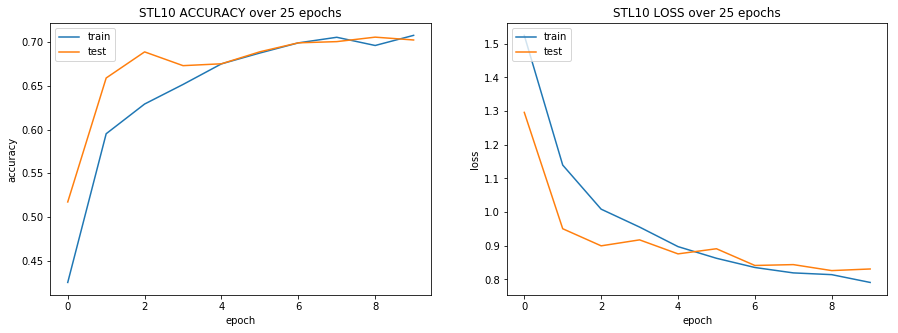

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(mod2.history['acc'])
plt.plot(mod2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('STL10 ACCURACY over 10 epochs')

plt.subplot(122)
plt.plot(mod2.history['loss'])
plt.plot(mod2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('STL10 LOSS over 10 epochs')
plt.show()